In [3]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from netCDF4 import Dataset
from sklearn.metrics import r2_score

1. Read model output fluoroscence.csv.
2. Read TROPOMI SIF data. 
3. Make comparison

In [4]:
path_TROPOMI_SIF = "/home/khanalp/data/processed/tropomisif"
path_model_output_nc = "/home/khanalp/data/processed/output_pystemmus"
path_station_info ="/home/khanalp/code/PhD/preprocessICOSdata/csvs/02_station_with_elevation_heightcanopy.csv"
# Path to the root folder containing model output folders for each station
pystemmus_output_model_folder = "/home/khanalp/STEMMUS_SCOPE_model/STEMMUS_SCOPE_old/STEMMUS_SCOPE/ICOS_sites/"

In [5]:
df_station_info = pd.read_csv(path_station_info)

/home/khanalp/tmp/ipykernel_1783106/3694118404.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fluoroscence_csv_selected_743_758['mean'] = df_fluoroscence_csv_selected_743_758.mean(axis=1)


<Figure size 640x480 with 0 Axes>

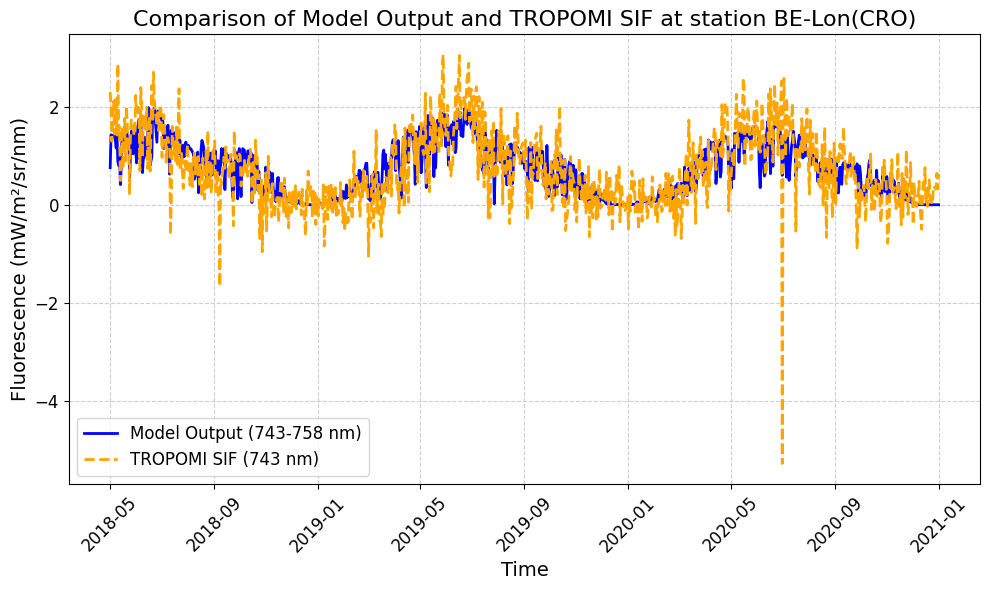

<Figure size 640x480 with 0 Axes>

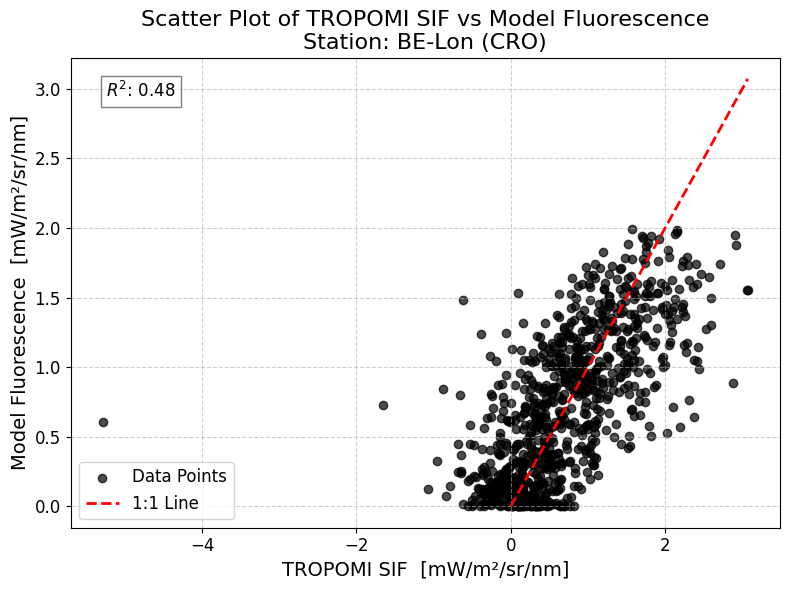

In [6]:
for station_name in df_station_info.station_name:
    # The nc file contains the latest model run , which are used in comparison. 
    file_name = [f for f in os.listdir(path_model_output_nc) if station_name in f] 
    # This is basically the .nc file which contains model output fluxes, others, etc but does not have fluoroscence.csv. 
    # I need it to align the timestamps because fluoroscene.csv does not have timestamps.
    path_model_output_station = [os.path.join(path_model_output_nc, f) for f in os.listdir(path_model_output_nc) if station_name in f]
    if path_model_output_station:
        ds_model_output = xr.open_dataset(path_model_output_station[0])
    # The filename is in format, 'BE-Lon_2024-04-15-1359_STEMMUS_SCOPE.nc', basically 2024-04-15-1359 is the required identifier to know the proper model run. 
    folder_identifier  = file_name[0].split('_')[1]
    # So, First i need to find the folder corresponding to the station name in the pystemmus output folder, which contains all the model runs for all the stations and different model run version. 
    required_folder_station = [os.path.join(pystemmus_output_model_folder, f) for f in os.listdir(pystemmus_output_model_folder) if station_name in f]
    # After I find the corresponding station, to go to particular model run output, I further need to select the model run with "folder_identifier" in the name.
    required_model_run_folder = [os.path.join(required_folder_station[0], "output", f) for f in os.listdir(os.path.join(required_folder_station[0],"output")) if folder_identifier in f]
    # The fluoroscene.csv is fluoroscence per simulation for wavelengths of 640 to 850 nm (w/m-2um-1sr-1). 
    # #It describes radiance, which is the amount of energy emitted, transmitted, or received per unit area, per unit wavelength, and per unit solid angle.
    df_fluoroscence_csv = pd.read_csv(
    os.path.join(required_model_run_folder[0], "fluorescence.csv"),
    skiprows=2,
    header=None
    )
    # Update the headers to represent wavelengths from 640 to 850 nm
    df_fluoroscence_csv.columns = [f"{wavelength} nm" for wavelength in range(640, 851)]
    df_fluoroscence_csv.index = pd.to_datetime(ds_model_output.time.values)
    
    # I need to find the latitude and longitude of the corresponding station. 
    station_info = df_station_info[df_station_info['station_name'] == station_name]
    latitude = station_info['latitude'].values[0]
    longitude = station_info['longitude'].values[0]
    land_use = station_info['IGBP_short_name'].values[0]
    #  1. I need the model output @743-758nm .
    # 2. My model output is (w/m-2um-1sr-1) while TROPOMISIF is "mW/m2/sr/nm", I need to do unit conversion. 
    # 3. I need to select only time closest to the tropomi_sif observation
    
    filename_tropomi_sif = [f for f in os.listdir(path_TROPOMI_SIF) if station_name in f] 
    df_tropomi_sif = pd.read_csv(os.path.join(path_TROPOMI_SIF, filename_tropomi_sif[0]))
    df_tropomi_sif['time'] = pd.to_datetime(df_tropomi_sif['time'])
    df_tropomi_sif_filtered = df_tropomi_sif[df_tropomi_sif['time'] <= df_fluoroscence_csv.index.max()]
    
    # getting closest observations in the model output data to the TROPOMI SIF data
    df_fluoroscence_csv.index = pd.to_datetime(df_fluoroscence_csv.index)
    closest_times = df_fluoroscence_csv.index.get_indexer(df_tropomi_sif_filtered['time'], method='nearest')
    df_fluoroscence_csv_selected = df_fluoroscence_csv.iloc[closest_times]
    
    # select only 753 to 758 nm
    df_fluoroscence_csv_selected_743_758 = df_fluoroscence_csv_selected.loc[:, "743 nm":"758 nm"]
    df_fluoroscence_csv_selected_743_758['mean'] = df_fluoroscence_csv_selected_743_758.mean(axis=1)
    
    # Time series plot
    plt.clf()
    plt.figure(figsize=(10, 6))
    plt.plot(df_tropomi_sif_filtered['time'], df_fluoroscence_csv_selected_743_758['mean'].values.flatten(), label='Model Output (743-758 nm)', color='blue', linestyle='-', linewidth=2)
    plt.plot(df_tropomi_sif_filtered['time'], df_tropomi_sif_filtered['SIF_743'].values.flatten(), label='TROPOMI SIF (743 nm)', color='orange', linestyle='--', linewidth=2)

    # Add labels, title, and legend
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Fluorescence (mW/m²/sr/nm)', fontsize=14)
    plt.title('Comparison of Model Output and TROPOMI SIF', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Improve tick formatting
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)

    # Tight layout for better spacing
    plt.tight_layout()
    plt.title(f'Comparison of Model Output and TROPOMI SIF at station {station_name}({land_use})', fontsize=16)
    # Save the plot as a high-resolution image (optional)
    # plt.savefig('comparison_plot.png', dpi=300)

    plt.show() 
    
    ## Scatter plot 
    plt.clf()
    plt.figure(figsize=(8, 6))

    # Scatter plot
    plt.scatter(df_tropomi_sif_filtered['SIF_743'], df_fluoroscence_csv_selected_743_758['mean'], 
                color='black', alpha=0.7, edgecolor='k', label='Data Points')

    # Calculate R-squared value
    r2 = r2_score(df_tropomi_sif_filtered['SIF_743'], df_fluoroscence_csv_selected_743_758['mean'])

    # Add R-squared value to the plot
    plt.text(0.05, 0.95, f'$R^2$: {r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    # Add a 1:1 line for reference
    max_val = max(df_tropomi_sif_filtered['SIF_743'].max(), df_fluoroscence_csv_selected_743_758['mean'].max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='1:1 Line')

    # Add labels, title, and legend
    plt.xlabel('TROPOMI SIF  [mW/m²/sr/nm]', fontsize=14)
    plt.ylabel('Model Fluorescence  [mW/m²/sr/nm]', fontsize=14)
    plt.title(f'Scatter Plot of TROPOMI SIF vs Model Fluorescence\nStation: {station_name} ({land_use})', fontsize=16)
    plt.legend(fontsize=12)

    # Improve tick formatting
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # Tight layout for better spacing
    plt.tight_layout()

    # Save the plot as a high-resolution image (optional)
    # plt.savefig('scatter_plot.png', dpi=300)

    plt.show()
    break

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df_comparision_SIF = pd.read_csv("/home/khanalp/code/PhD/daytoday/SIFcomparison/comparison_results.csv")
df_comparision_SIF

,station_name,land_use,r_squared,num_observations
0,BE-Lon,CRO,0.475121,891
1,CH-Oe2,CRO,0.439676,559
2,CZ-KrP,CRO,0.309158,890
3,DE-Geb,CRO,0.404399,560
4,DE-Kli,CRO,0.303324,560
...,...,...,...,...
60,CZ-wet,WET,-0.644090,560
61,FI-Sii,WET,-0.450470,560
62,FR-LGt,WET,-0.134075,559
63,SE-Deg,WET,-0.693094,891


In [11]:
best_stations = df_comparision_SIF.loc[df_comparision_SIF.groupby('land_use')['r_squared'].idxmax()]
print(best_stations)

   station_name land_use  r_squared  num_observations
0        BE-Lon      CRO   0.475121               891
10       BE-Maa      CSH  -0.200375               560
16       DK-Sor      DBF   0.544353               891
19       GF-Guy      EBF  -1.954663               559
37       RU-Fyo      ENF   0.297695               560
42       BE-Dor      GRA   0.521313               891
52       BE-Bra       MF   0.087529               560
56       IT-Lsn      OSH   0.404005               891
57       ES-Abr      SAV  -0.353237               891
62       FR-LGt      WET  -0.134075               559
64       ES-Cnd      WSA  -0.409034               890


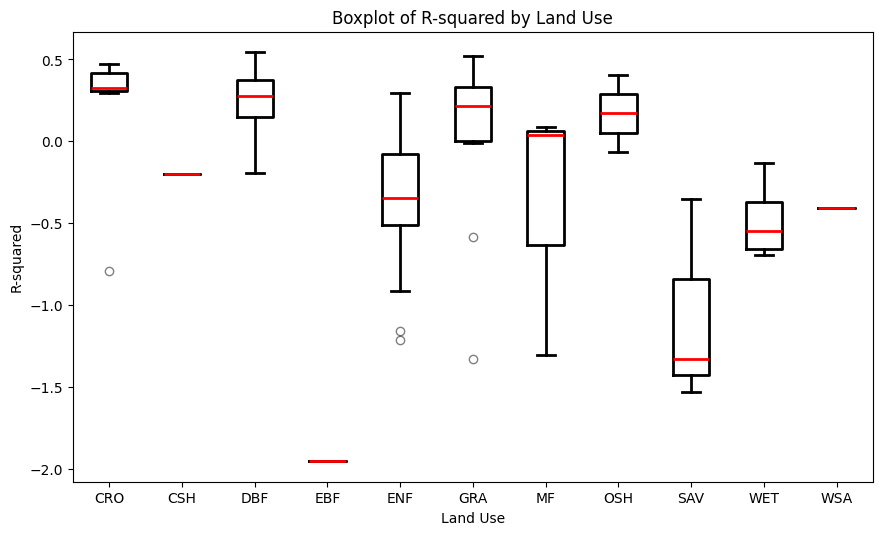

In [10]:
# Group by land_use and create a boxplot for r_squared
df_comparision_SIF.boxplot(column='r_squared', by='land_use', figsize=(10, 6), grid=False, 
                           boxprops=dict(linewidth=2), 
                           medianprops=dict(color='red', linewidth=2), 
                           whiskerprops=dict(linewidth=2), 
                           capprops=dict(linewidth=2), 
                           flierprops=dict(marker='o', color='black', alpha=0.5))

# Add labels and title
plt.title('Boxplot of R-squared by Land Use')
plt.suptitle('')  # Remove the default Pandas title
plt.xlabel('Land Use')
plt.ylabel('R-squared')

# Show the plot
plt.show()